In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import numpy as np
from imblearn.over_sampling import SMOTE

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet("cic-collection.parquet")

In [4]:
df.head()


,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ClassLabel
0,4,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
1,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,3,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
4,609,7,4,484.0,414.0,233.0,69.14286,111.967896,207.0,103.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


In [5]:
df['Label'].unique()

array(['Benign', 'Botnet', 'Bruteforce-FTP', 'Bruteforce-SSH',
       'DoS-Slowbody', 'DoS-Slowread', 'DDoS-Ddossim', 'DoS-Goldeneye',
       'DoS-Slowheaders', 'DoS-Rudy', 'DoS-Hulk', 'DDoS-Slowloris',
       'DDoS', 'DDoS-LOIC-HTTP', 'DDoS-UDP', 'DDoS-HOIC', 'DDoS-DNS',
       'DoS-Slowloris', 'DoS-Slowhttptest', 'DoS-Heartbleed',
       'Infiltration', 'DDoS-LDAP', 'DDoS-NetBIOS', 'DDoS-MSSQL',
       'DDoS-NTP', 'Portscan', 'DDoS-SNMP', 'DDoS-Syn', 'DDoS-TFTP',
       'DDoS-UDPLag', 'Webattack-bruteforce', 'Webattack-XSS',
       'Webattack-SQLi'], dtype=object)

In [6]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == "Benign" else 1)

In [7]:
df = df.drop_duplicates()
df = df.dropna()

In [8]:
df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count',
       'URG Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size',
       'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Subflow Bwd By

In [9]:
df.drop("ClassLabel", axis=1,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9167271 entries, 0 to 9167580
Data columns (total 58 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Flow Duration             int64  
 1   Total Fwd Packets         int32  
 2   Total Backward Packets    int32  
 3   Fwd Packets Length Total  float64
 4   Bwd Packets Length Total  float64
 5   Fwd Packet Length Max     float64
 6   Fwd Packet Length Mean    float32
 7   Fwd Packet Length Std     float32
 8   Bwd Packet Length Max     float64
 9   Bwd Packet Length Mean    float32
 10  Bwd Packet Length Std     float32
 11  Flow Bytes/s              float64
 12  Flow Packets/s            float64
 13  Flow IAT Mean             float32
 14  Flow IAT Std              float32
 15  Flow IAT Max              float64
 16  Flow IAT Min              float64
 17  Fwd IAT Total             float64
 18  Fwd IAT Mean              float32
 19  Fwd IAT Std               float32
 20  Fwd IAT Max               flo

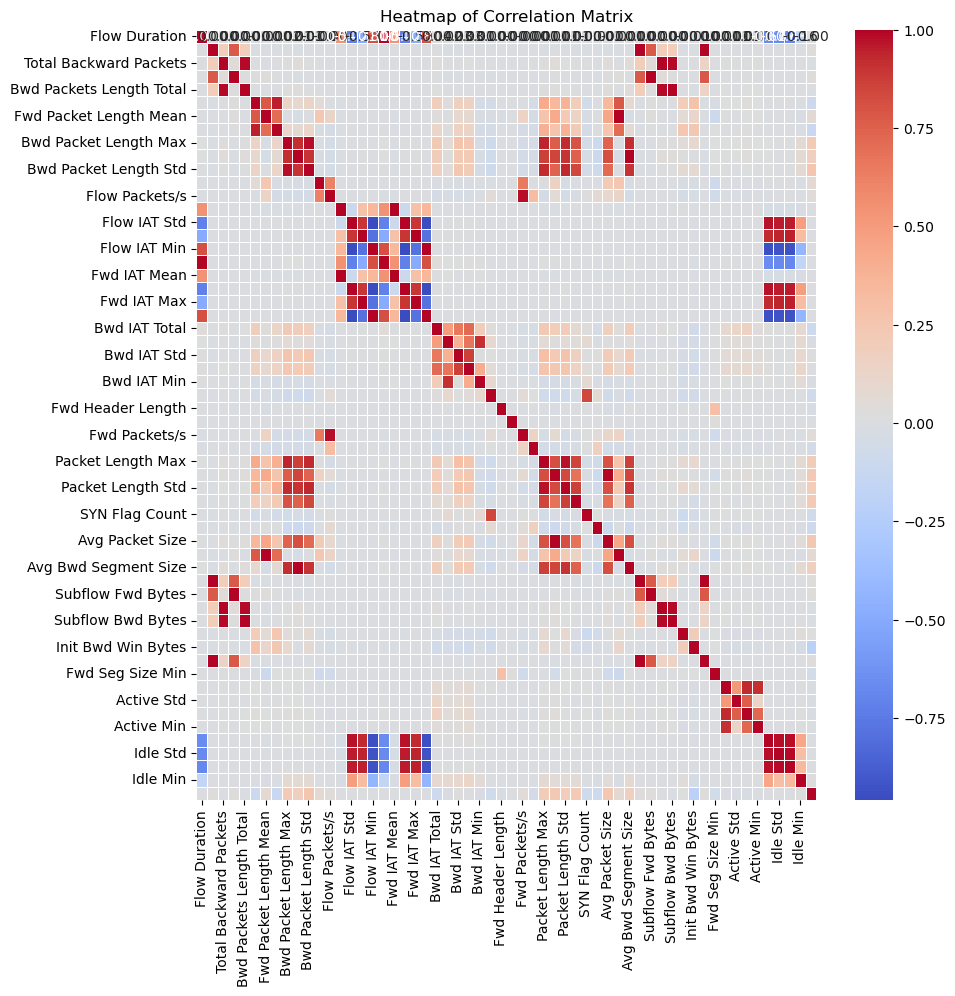

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))  # Set the figure size (optional)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [12]:
# https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python -> Code from there
correlation_matrix = correlation_matrix.abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
dropped_df = df.drop(to_drop, axis=1)

In [13]:
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9167271 entries, 0 to 9167580
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Flow Duration           int64  
 1   Total Fwd Packets       int32  
 2   Total Backward Packets  int32  
 3   Fwd Packet Length Max   float64
 4   Bwd Packet Length Max   float64
 5   Flow Bytes/s            float64
 6   Flow Packets/s          float64
 7   Flow IAT Mean           float32
 8   Bwd IAT Total           float64
 9   Bwd IAT Mean            float32
 10  Bwd IAT Std             float32
 11  Fwd PSH Flags           int8   
 12  Fwd Header Length       int64  
 13  Bwd Header Length       int64  
 14  Bwd Packets/s           float32
 15  URG Flag Count          int8   
 16  Init Fwd Win Bytes      int32  
 17  Init Bwd Win Bytes      int32  
 18  Fwd Seg Size Min        int32  
 19  Active Mean             float32
 20  Active Std              float32
 21  Idle Min                float64
 22 

In [14]:
dropped_df.tail()


,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packet Length Max,Bwd Packet Length Max,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Bwd IAT Total,Bwd IAT Mean,...,Bwd Header Length,Bwd Packets/s,URG Flag Count,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Label
9167576,44797921,6,5,6.0,0.0,8.036087e-01,0.245547,4.479792e+06,40100000.0,1.000000e+07,...,160,0.111612,0,256,290,20,23663.5,108.36512,10000000.0,0
9167577,49,3,0,45.0,0.0,1.551020e+06,61224.489800,2.450000e+01,0.0,0.000000e+00,...,0,0.000000,0,122,-1,32,0.0,0.00000,0.0,0
9167578,1286687,41,42,456.0,976.0,7.475011e+03,64.506753,1.569130e+04,339094.0,8.270585e+03,...,1360,32.641972,0,29200,243,32,0.0,0.00000,0.0,0
9167579,217,2,1,31.0,6.0,1.705069e+05,13824.884790,1.085000e+02,0.0,0.000000e+00,...,20,4608.294922,0,137,0,32,0.0,0.00000,0.0,0
9167580,1387547,41,46,456.0,976.0,6.747159e+03,62.700579,1.613427e+04,431936.0,9.598578e+03,...,1488,33.152031,0,29200,243,32,0.0,0.00000,0.0,0


In [15]:
columns_max = []
clean_df = dropped_df.copy()
for column in dropped_df.columns[1:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
            
    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR

    orig_val = len(clean_df)
    clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    columns_max.append(orig_val - len(clean_df))





In [16]:
print(columns_max)

[205892, 106611, 25474, 173018, 1257816, 386930, 968541, 662013, 166770, 53843, 90201, 17955, 1517, 251489, 81874, 291489, 1057034, 1906432, 83706, 0, 422, 573472]


#### Since I only have a 8GB M1 Mac I am unable to build a model with 9 million rows, thus we will use stratified sampling to get 100k  rows and make sure there is no class imbalance. 

In [18]:
final_df, _ = train_test_split(dropped_df, train_size=100000, stratify=dropped_df['Label'], random_state=42)

#### IQR may not work since a lot of data have outliers and these outliers may be important for anomaly detection. Thus, instead of using a standard scaler for scaling our data we can use a robust scaler which is better when we have more outliers  

In [20]:
X_feature_matrix = final_df.drop('Label', axis=1) 
y_target = final_df['Label']

In [21]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_feature_matrix)

In [22]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_feature_matrix.columns)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_target, test_size=0.2)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [24]:
#param_grid = {
#    'C': [0.001, 0.01, 0.1, 1],  
#    'gamma': [1, 0.1, 0.01, 0.001], 
#    'kernel': ['rbf', 'poly']  
#}

param_grid = {
   'C': [0.1, 1, 10],
   'gamma': ['scale', 'auto']
}
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, refit=True, cv=skf, verbose=10)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.1, gamma=scale..........................................
[CV 1/5; 1/6] END ...........C=0.1, gamma=scale;, score=0.567 total time= 4.6min
[CV 2/5; 1/6] START C=0.1, gamma=scale..........................................
[CV 2/5; 1/6] END ...........C=0.1, gamma=scale;, score=0.571 total time= 5.8min
[CV 3/5; 1/6] START C=0.1, gamma=scale..........................................
[CV 3/5; 1/6] END ...........C=0.1, gamma=scale;, score=0.572 total time= 5.8min
[CV 4/5; 1/6] START C=0.1, gamma=scale..........................................
[CV 4/5; 1/6] END ...........C=0.1, gamma=scale;, score=0.574 total time= 6.3min
[CV 5/5; 1/6] START C=0.1, gamma=scale..........................................
[CV 5/5; 1/6] END ...........C=0.1, gamma=scale;, score=0.574 total time= 5.5min
[CV 1/5; 2/6] START C=0.1, gamma=auto...........................................
[CV 1/5; 2/6] END ............C=0.1, gamma=auto;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
             verbose=10)

In [25]:
best_svc = grid_search.best_estimator_

y_pred = best_svc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     15687
           1       0.96      0.78      0.86      4313

    accuracy                           0.94     20000
   macro avg       0.95      0.88      0.91     20000
weighted avg       0.95      0.94      0.94     20000

